# Multi Head Attention

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
sequence_length = 4 # This is the maximum length of the input sequence(my name is Andrew)
batch_size = 1
input_dim  = 512  # this is the dimensional length of each input vector
d_model    = 512  # This is the dimensional length of the output vector from the attention head

x = torch.randn((batch_size, sequence_length, input_dim))  # this is a random input sequence. (This is being used coz we have not designed the position encoder yet.)


In [4]:
x.size()

torch.Size([1, 4, 512])

In [5]:
# create a query, key and value layer 
qkv_layer = nn.Linear(input_dim, 3*d_model) #we multiply by 3 so that we concatenate the 3 values of qkv
qkv = qkv_layer(x) # this is the concatenated value of query, key and value vector along the dimension axis (torch.Size([1, 4, 1536])) for each word


In [6]:
qkv.shape

torch.Size([1, 4, 1536])

Text(0.5, 1.0, 'qkv distribution')

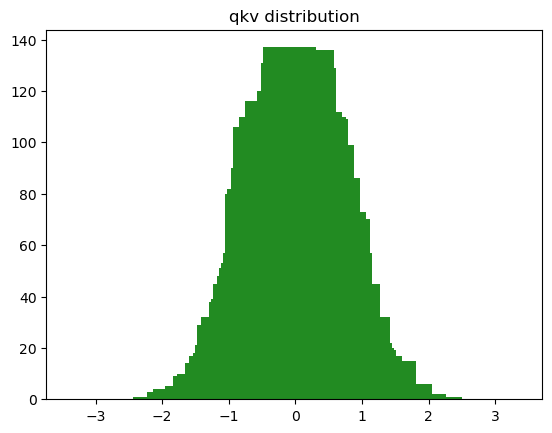

In [8]:
# just to check how all the values in the qkv vector are distributed.
import matplotlib.pyplot as plt
y_val = torch.histc(qkv, bins=200, min=-3, max=3)
x_val = np.arange(-1, 1, 0.01) * 3
plt.bar(x_val, y_val, align='center', color=['forestgreen'])
plt.title('qkv distribution')
     

In [9]:
######################################### Attention head #####################################################################
num_heads = 8 # no of attention heads
head_dim = d_model // num_heads
qkv = qkv.reshape(batch_size, sequence_length, num_heads, 3 * head_dim)


In [10]:
qkv.shape

torch.Size([1, 4, 8, 192])

In [11]:
qkv = qkv.permute(0, 2, 1, 3) #(batch_size, num_heads, sequence_length, 3*head). we do this so that its easier to perform parallel operations on these last two dims

In [12]:
qkv.shape

torch.Size([1, 8, 4, 192])

In [13]:
# access the individual Q, K, V by splitting qkv into 3 chunks along the last dimension 
Q, K, V = torch.chunk(qkv, 3, dim=-1)


In [15]:
Q.shape, K.shape, V.shape

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

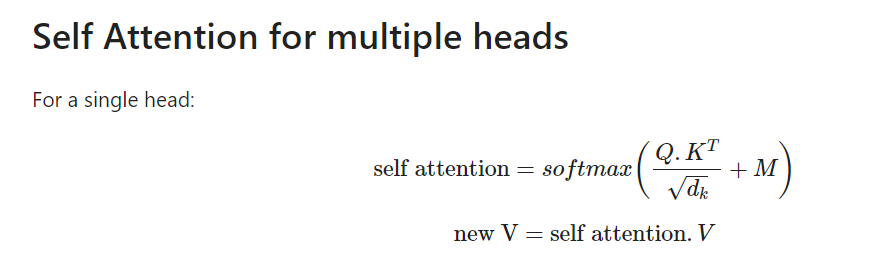

In [18]:
import math
d_k = Q.size()[-1]
scaled = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)
scaled.shape
     

torch.Size([1, 8, 4, 4])

# mask

In [23]:
mask = torch.full(scaled.size() , float('-inf')) # we use -inf coz when we apply softmax, the exp(-inf)= 0 and this helps in the model not to cheat by looking in the future
mask = torch.triu(mask, diagonal=1)
mask = torch.triu(mask, diagonal=1)
mask[0][1] # mask for input to a single head

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [25]:
(scaled + mask)[0][0]  # this is a mask for input to a single head

tensor([[-0.0848,    -inf,    -inf,    -inf],
        [-0.3235, -0.7170,    -inf,    -inf],
        [ 0.3544, -0.0331,  0.1385,    -inf],
        [-0.1230,  0.6127,  0.1158, -0.0849]], grad_fn=<SelectBackward0>)

In [26]:
scaled += mask

In [27]:
np.exp(0.5596) / (np.exp(0.5596) + np.exp(0.0404))

0.6269606805367254

In [28]:
attention = F.softmax(scaled, dim=-1)

In [29]:
attention.shape

torch.Size([1, 8, 4, 4])

In [30]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.5971, 0.4029, 0.0000, 0.0000],
        [0.4025, 0.2732, 0.3243, 0.0000],
        [0.1853, 0.3868, 0.2353, 0.1925]], grad_fn=<SelectBackward0>)

In [32]:
values = torch.matmul(attention, V)
values.shape
     

torch.Size([1, 8, 4, 64])

# Function

In [33]:
import math

def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

In [35]:
values, attention = scaled_dot_product(Q, K, V, mask=mask)

In [36]:
attention.shape

torch.Size([1, 8, 4, 4])

In [37]:

attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.5971, 0.4029, 0.0000, 0.0000],
        [0.4025, 0.2732, 0.3243, 0.0000],
        [0.1853, 0.3868, 0.2353, 0.1925]], grad_fn=<SelectBackward0>)

In [38]:

values.size()

torch.Size([1, 8, 4, 64])

In [39]:
values = values.reshape(batch_size, sequence_length, num_heads * head_dim)
values.size()

torch.Size([1, 4, 512])

In [40]:
######################### FEED FORWARD PASS ####################################
linear_layer = nn.Linear(d_model, d_model)
out = linear_layer(values) # this gives a rich output vector with more context aware

In [41]:
out.shape

torch.Size([1, 4, 512])

In [42]:
out

tensor([[[-0.3668, -0.5315, -0.3490,  ...,  0.1602, -0.1891, -0.5362],
         [ 0.0560, -0.1489,  0.4182,  ...,  0.1622, -0.3183,  0.1609],
         [ 0.3462,  0.3987,  0.3355,  ..., -0.3296, -0.0735, -0.0957],
         [ 0.0642,  0.1206, -0.3855,  ..., -0.2958,  0.1321, -0.4862]]],
       grad_fn=<ViewBackward0>)